In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit
from qiskit.tools.visualization import circuit_drawer, plot_histogram, plot_state
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QuantumProgram
from qiskit import available_backends, execute

In [3]:
def input_state(circuit, f_in, f_out):
    circuit.h(f_in)

    circuit.x(f_out)
    circuit.h(f_out)


def black_box_u_f(circuit, f_in, f_out, aux, n):
    if n == 2:
        circuit.h(f_in[1])
        circuit.cx(f_in[0], f_in[1])
        circuit.h(f_in[1])
    
# def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
#     """Circuit that computes the black-box function from f_in to f_out.
#     Create a circuit that verifies whether a given exactly-1 3-SAT
#     formula is satisfied by the input. The exactly-1 version
#     requires exactly one literal out of every clause to be satisfied.
#     """
#     num_clauses = len(exactly_1_3_sat_formula)
#     for (k, clause) in enumerate(exactly_1_3_sat_formula):
#         # This loop ensures aux[k] is 1 if an odd number of literals
#         # are true
#         for literal in clause:
#             if literal > 0:
#                 circuit.cx(f_in[literal-1], aux[k])
#             else:
#                 circuit.x(f_in[-literal-1])
#                 circuit.cx(f_in[-literal-1], aux[k])
#         # Flip aux[k] if all literals are true, using auxiliary qubit
#         # (ancilla) aux[num_clauses]
#         circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
#         circuit.ccx(f_in[2], aux[num_clauses], aux[k])
#         # Flip back to reverse state of negative literals and ancilla
#         circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
#         for literal in clause:
#             if literal < 0:
#                 circuit.x(f_in[-literal-1])
#     # The formula is satisfied if and only if all auxiliary qubits
#     # except aux[num_clauses] are 1
#     if (num_clauses == 1):
#         circuit.cx(aux[0], f_out[0])
#     elif (num_clauses == 2):
#         circuit.ccx(aux[0], aux[1], f_out[0])
#     elif (num_clauses == 3):
#         circuit.ccx(aux[0], aux[1], aux[num_clauses])
#         circuit.ccx(aux[2], aux[num_clauses], f_out[0])
#         circuit.ccx(aux[0], aux[1], aux[num_clauses])
#     else:
#         raise ValueError('We only allow at most 3 clauses')
#     # Flip back any auxiliary qubits to make sure state is consistent
#     # for future executions of this routine; same loop as above.
#     for (k, clause) in enumerate(exactly_1_3_sat_formula):
#         for literal in clause:
#             if literal > 0:
#                 circuit.cx(f_in[literal-1], aux[k])
#             else:
#                 circuit.x(f_in[-literal-1])
#                 circuit.cx(f_in[-literal-1], aux[k])
#         circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
#         circuit.ccx(f_in[2], aux[num_clauses], aux[k])
#         circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
#         for literal in clause:
#             if literal < 0:
#                 circuit.x(f_in[-literal-1])
# -- end function


def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function


def inversion_about_average(circuit, f_in, n):
    circuit.h(f_in)
    circuit.x(f_in)
    
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])

    circuit.x(f_in)
    circuit.h(f_in)

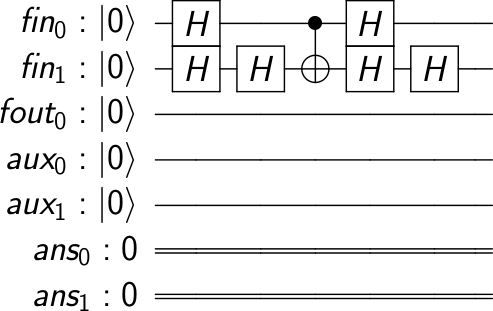

In [4]:
n = 2

# exactly_1_3_sat_formula = [[1], [2], [3]]
exactly_1_3_sat_formula = [[1, 2, 3]]

QPS_SPECS = {
    'circuits': [{
        'name': 'grover',
        'quantum_registers': [
            {'name': 'fin', 'size': n},
            {'name': 'fout', 'size': 1},
            {'name': 'aux', 'size': len(exactly_1_3_sat_formula) + 1},
        ],
        'classical_registers': [
            {'name': 'ans', 'size': n},
        ]}]
}

qp = QuantumProgram(specs=QPS_SPECS)
qc = qp.get_circuit('grover')
f_in = qp.get_quantum_register('fin')
f_out = qp.get_quantum_register('fout')
aux = qp.get_quantum_register('aux')
ans = qp.get_classical_register('ans')

# input_state(qc, f_in, f_out)
qc.h(f_in)
black_box_u_f(qc, f_in, f_out, aux, n)
qc.h(f_in)
# black_box_u_f(qc, f_in, f_out, aux, n, exactly_1_3_sat_formula)
# inversion_about_average(qc, f_in, n)

# qc.measure(f_in, ans)
    
circuit_drawer(qc)

In [19]:
result = qp.execute(['grover'], backend='local_statevector_simulator_py', shots=1)
state = result.get_data('grover')['statevector'][:4]

# counts = result.get_counts('grover')
# plot_histogram(counts)

In [7]:
def state_2_rho(state):
    return np.outer(state, state.conj())

rho_superposition=state_2_rho(state)
print(rho_superposition)

[[ 0.25+0.00000000e+00j  0.25+6.12323400e-17j  0.25+6.12323400e-17j
  -0.25-1.22464680e-16j]
 [ 0.25-6.12323400e-17j  0.25+0.00000000e+00j  0.25-1.23259516e-32j
  -0.25-6.12323400e-17j]
 [ 0.25-6.12323400e-17j  0.25+1.23259516e-32j  0.25+0.00000000e+00j
  -0.25-6.12323400e-17j]
 [-0.25+1.22464680e-16j -0.25+6.12323400e-17j -0.25+6.12323400e-17j
   0.25+0.00000000e+00j]]


In [8]:
state

array([ 0.5-1.23259516e-32j,  0.5-1.22464680e-16j,  0.5-1.22464680e-16j,
       -0.5+2.44929360e-16j])

In [9]:
states = ['00', '01', '10', '11']

In [42]:
state.real

array([ 0.5,  0.5,  0.5, -0.5])

In [53]:
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
test = QuantumCircuit(qubits, clbits)
test.initialize([ 0.5,  0.5,  0.5, -0.5], [qubits[i] for i in range(2)])

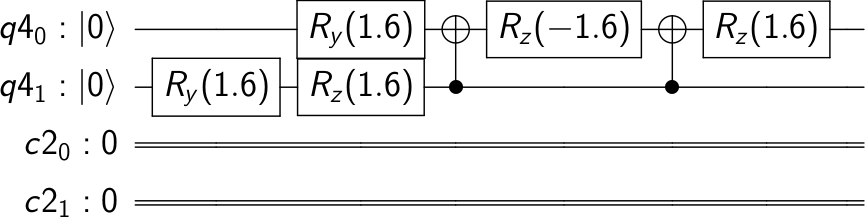

In [54]:
circuit_drawer(test)

In [55]:
execute(test, backend='local_statevector_simulator_py', shots=1).result().get_data()['statevector']

array([ 0.5+0.000000e+00j,  0.5+0.000000e+00j,  0.5+0.000000e+00j,
       -0.5+6.123234e-17j])

In [18]:
state

array([ 0.5-1.23259516e-32j,  0.5-1.22464680e-16j,  0.5-1.22464680e-16j,
       -0.5+2.44929360e-16j])

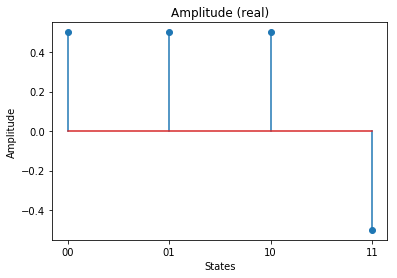

In [41]:
plt.figure()
plt.locator_params(axis='x', nbins=4)
x = [1, 2, 3, 4]
plt.stem(x, state.real)
plt.xticks(x, states)
plt.title('Amplitude (real)')
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.show()

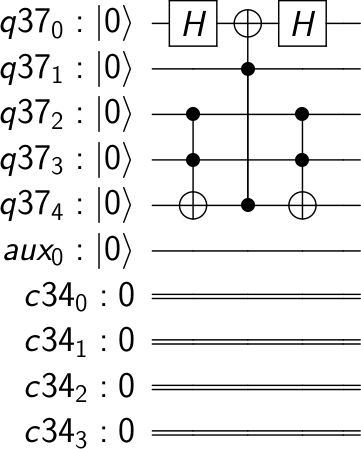

In [98]:
def _n_controlled_Z_12(circuit, controls, target):
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

def left(circuit, qubits, n, total_qubits):
    for i in range(n):
        tgt = total_qubits - n + i
        ctl1 = 1 + n - i
        ctl2 = tgt - 1
        circuit.ccx(qubits[ctl1], qubits[ctl2], qubits[tgt])  # Last is target.

def right(circuit, qubits, n, total_qubits):
    for i in reversed(range(n)):
        tgt = total_qubits - n + i
        ctl1 = 1 + n - i
        ctl2 = tgt - 1
        circuit.ccx(qubits[ctl1], qubits[ctl2], qubits[tgt])  # Last is target.
        
n = 3  # Number of controls.
total_qubits = 1 + n + (n - 2)

q = QuantumRegister(total_qubits)
aux = QuantumRegister(n - 2, name='aux')

c = ClassicalRegister(1 + n)

qc = QuantumCircuit(q, aux, c)

left(qc, q, n - 2, total_qubits)
n_controlled_Z(qc, [q[1], q[total_qubits - 1]], q[0])
right(qc, q, n - 2, total_qubits)

circuit_drawer(qc)

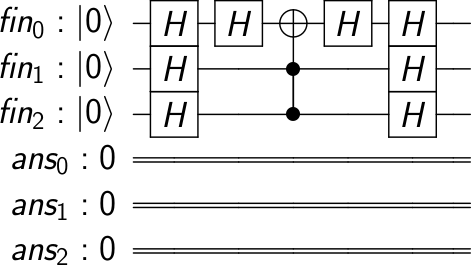

In [270]:
def n_controlled_Z_12(circuit, controls, target):
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is implemented as different function')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

def n_controlled_Z(circuit, controls, target, aux):
    if len(controls) <= 2:
        _n_controlled_Z_12(qc, controls, target)
    else:
        # Left.
        qc.ccx(controls[1], controls[2], aux[0])
        for k, control_qubit in enumerate(controls[3:], 1):
            qc.ccx(control_qubit, aux[k - 1], aux[k])
        # Center.
        n_controlled_Z_12(qc, [controls[0], aux[len(controls[3:])]], target)
        # Right.
        for k, control_qubit in enumerate(reversed(controls[3:]), 1):
            qc.ccx(control_qubit, aux[len(controls[3:]) - k], aux[len(controls[3:]) - k + 1])
        qc.ccx(controls[1], controls[2], aux[0])
        
n = 3  # Number of qubits.
f_in = QuantumRegister(n, name='fin')
c = ClassicalRegister(n, name='ans')

target = f_in[0]
controls = [f_in[i] for i in range(1, 3)]

aux = None
qc = None
if len(controls) > 2:
    aux = QuantumRegister(len(controls) - 2, name='aux')
    qc = QuantumCircuit(f_in, aux, c)
else:
    qc = QuantumCircuit(f_in, c)
    
qc.h(f_in)
n_controlled_Z(qc, controls, target, aux)
qc.h(f_in)

circuit_drawer(qc)

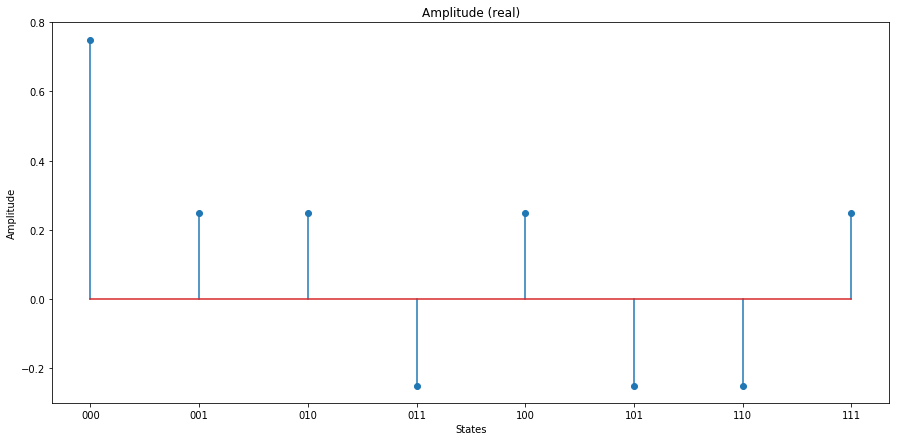

In [271]:
n_ctl = len(controls) + 1
statevector = execute(qc, backend='local_statevector_simulator_py', shots=1).result().get_data()['statevector']
statevector = statevector[:2 ** n_ctl]

plt.figure(figsize=(15, 7))
x = np.arange(1, 1 + 2 ** n_ctl)
states = list(map(lambda x: ''.join(map(str, x)), itertools.product([0, 1], repeat=n_ctl)))
plt.stem(x, statevector.real)
plt.xticks(x, states)
plt.title('Amplitude (real)')
plt.xlabel('States')
plt.ylabel('Amplitude')
plt.show()

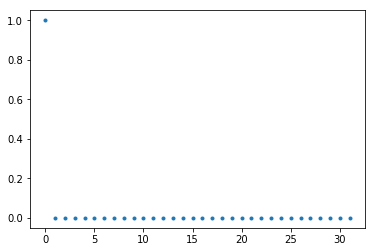

In [89]:
plt.plot(execute(qc, backend='local_statevector_simulator_py', shots=1).result().get_data()['statevector'].real, '.')

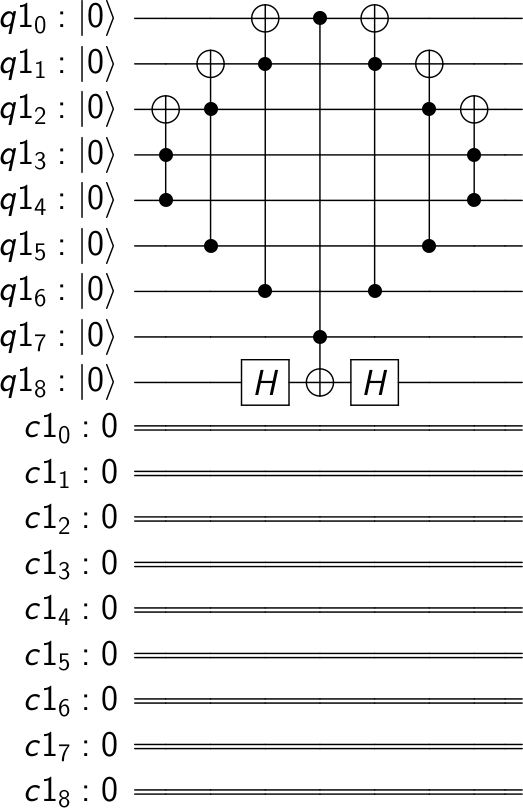

In [11]:
def left(circuit, qubits, n):
    for i in range(n - 2):
        circuit.ccx(qubits[i + n - 1], qubits[n - 2 - i], qubits[n - 3 - i])  # Last is target.
        
def right(circuit, qubits, n):
    for i in reversed(range(n - 2)):
        circuit.ccx(qubits[i + n - 1], qubits[n - 2 - i], qubits[n - 3 - i])  # Last is target.

q = QuantumRegister(9)
c = ClassicalRegister(9)
qc = QuantumCircuit(q, c)
left(qc, q, 5)
n_controlled_Z(qc, [q[0], q[7]], q[8])
right(qc, q, 5)
circuit_drawer(qc)

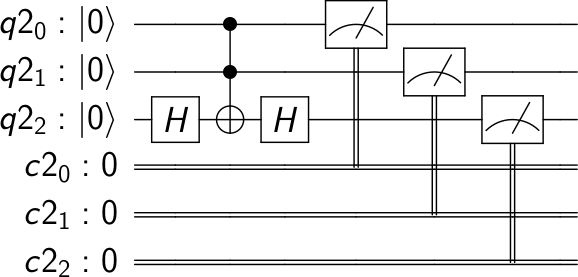

In [12]:
# desired_vector = []

q = QuantumRegister(3)
c = ClassicalRegister(3)

qc = QuantumCircuit(q, c)
# qc.cx(q[0], q[1])
# qc.cx(q[0], q[1])
n_controlled_Z(qc, [q[0], q[1]], q[2])

# qc.initialize(desired_vector, [q[0],q[1],q[2]])
qc.measure(q, c)
circuit_drawer(qc)

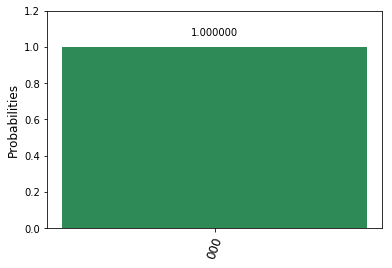

In [13]:
backend = 'local_qasm_simulator'
plot_histogram(execute(qc, backend, shots=8192).result().get_data()['counts'])

In [14]:
import itertools

def get_all_states(n):
    all_states = np.array(list(map(np.array, itertools.product([0, 1], repeat=n))))
    return all_states

In [15]:
def sat(f, set_of_values):
    results = []
    for values in set_of_values:
        res = 1
        for clause in f:
            tmp = 0
            for literal in clause:
                if literal > 0:
                    tmp |= values[abs(literal) - 1]
                else:
                    tmp |= 1 - values[abs(literal) - 1]
            res *= tmp
        results.append(res)
    return results

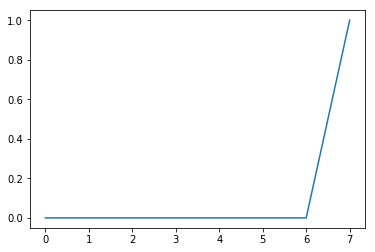

In [53]:
# exactly_1_3_sat_formula = [[1, -2, -3],
#                            [1, -2, 3],
#                            [1, 2, -3],
#                            [-1, -2, 3],
#                            [-1, 2, -3],
#                            [1, 2, 3],
#                            [1, -2, 3],
#                            [-1, -2, -3]]
# exactly_1_3_sat_formula = [[1, 2], [-2, 3], [-1, -3]]
# exactly_1_3_sat_formula = [[1], [2], [3]]
res = sat(exactly_1_3_sat_formula, get_all_states(3))
plt.plot(res)

In [18]:
import pycosat

In [54]:
pycosat.solve(exactly_1_3_sat_formula)

[1, 2, 3]